# Classifying New Data
Using the XGBoost model

### Importing Libraries and Model

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import _pickle as pickle
import numpy as np
import pandas as pd
from joblib import load
from sklearn.preprocessing import StandardScaler

# Preventing error from occuring: XGBoost causes kernel to die.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
import xgboost as xgb

### Loading in the Pretrained Model

In [2]:
# Loading Pretrained XGBoost Model
clf = load("xgboost_top10_feats_final_model.joblib")

### Loading in the Data

In [3]:
# Using the Stockpup dataset to find the latest QR
with open("stockpup.pkl", 'rb') as fp:
    stock_df = pickle.load(fp)
    
# Using Top 10 Features to scale with the latest QR    
with open("Top-10-Features-Models/top10_df.pkl", "rb") as fp:
    top10_df = pickle.load(fp)    

Ideally, we would be using the most up-to-date QR for any stock we choose.  Need to scrape a web source or find values manually for such values.

## Helper Functions

In [43]:
def format_qr(df, df2):
    """
    Formats the DF from the Stockpup dataset so that the values and columns line up with training and testing data
    Uses the second DF of our data to find the appropriate feature columns to use and will be appended to
    Scales the DF with the new data
    Returns the QR with the new scaled data
    """
    # Dropping the class column as it is not needed
    df2 = df2.drop("Decision", axis=1)
    
    # Setting the Datetime index
    df['Quarter end'] = pd.to_datetime(df['Quarter end'])
    df = df.set_index("Quarter end")
    
    # Sort the DF based on date
    df = df.sort_index(ascending=False)
    
    # Finding the latest values
    df = df.head(2)
    
    # Replacing 'None' with 0
    df = df.replace("None", 0)
    
    # Converting all values to numeric
    df = df.apply(pd.to_numeric)
    
    # Finding the percent change
    df = df.pct_change(-1).apply(lambda x: x*100)
    
    # Using only the latest QR
    df = df.head(1)
    
    # Replacing values with 0
    df = df.replace([np.inf, -np.inf], [1,-1]).fillna(0)
    
    # Using only the columns with the data that we have (excluding the class labels)
    df = df[df2.columns]
    
    # Appending the new data to rest of the data for scaling purposes
    df = df2.append(df)
    
    # Scaling the data
    scaler = StandardScaler()
    
    df = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
    
    # Finding the latest scaled QR
    df = df.tail(1)
    
    # Returning the latest scaled QR with the appropriate features
    return df

In [64]:
def prediction(pred):
    """
    Returns the class label for the prediction
    """
    if pred == 1.0:
        print('BUY')
    elif pred == 0.0:
        print('SELL')
    else:
        print('HOLD')
    

In [60]:
def pie_stock(pred, name):
    """
    Creates a pie chart of the stock class predictions
    """
    rcParams['font.size'] = 30.0
    plt.style.use('bmh')
    plt.figure(figsize=(10,10))
    plt.pie(pred[0], 
            labels=['SELL', 'BUY','HOLD'], 
            shadow=True,
            explode=(.05,.05,.05),
            autopct='%1.1f%%')
    plt.title(name)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

## Retrieving the Latest Quarterly Report

Using the latest QR from AMD as an example

In [55]:
# Viewing the DF with the latest scaled QR
qr_df = format_qr(stock_df['AMD'], top10_df)
qr_df

,P/B ratio,Assets,Shares split adjusted,Shares,P/E ratio,Liabilities,Asset turnover,Current Assets,Cash at end of period,Revenue
2019-06-29 00:00:00,-0.008971,0.00482,-0.021878,-0.106576,-0.006956,-0.03409,-0.393605,-0.005693,-0.004474,-0.004161


### Using our Classifier to make a new Prediction

In [65]:
# Predicting the class for our latest QR
class_label = clf.predict(qr_df)[0]

prediction(class_label)

HOLD


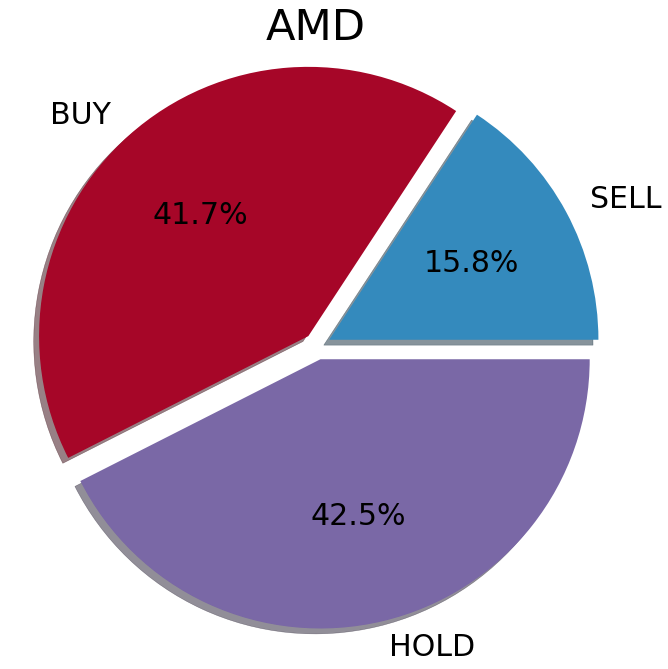

In [61]:
# Visualizing the Prediction probabilities for our latest QR
pie_stock(clf.predict_proba(qr_df), "AMD")

__Interpretation__: According to our classifier, AMD has a 42.5% chance of being a 'Hold'.